In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

#### At first there is some analysis and then implementation

### Getting the data and preprocessing it

In [2]:
#Loading data into dataframes

data_folder = "data"

movies = pd.read_csv(os.path.join(data_folder, "movies.csv")).drop("genres", axis=1) # We do not need genres right at the start
ratings = pd.read_csv(os.path.join(data_folder, "ratings.csv")).drop("timestamp", axis=1) # timestap not needed too

In [3]:
#Creating a mapping from film_id to film name
movies_mapping = {}
for index, row in movies.iterrows():
    movies_mapping[row.movieId] = row.title

In [4]:
#Leaving only reviews that are either positive or negative and then binarizing them
mask_with_useful_ratings = (ratings.rating >=4)  | (ratings.rating <= 2)

#I do not perform splitting here as Ill need later this frame for genres.
useful_ratings = ratings.loc[mask_with_useful_ratings,:].copy() #Withouth this Pandas was raising a warning about performing operation on slices. 

useful_ratings["rating"] = useful_ratings.rating.apply(lambda x: 1 if x >= 4 else -1)

In [5]:
#Getting number of users and their Id's, moreover I was wondering if I should use test set.
#At the beginning I've tried to use test set but then I didn't know how to evaluate these rules based on the test set so I give up
#While creating and association rules
users = useful_ratings.userId.unique()
num_of_users = users.size

#size_of_test_set = 0.01
#users_test, users_train = users[:int(num_of_users*size_of_test_set)], users[int(num_of_users*size_of_test_set):]
users_train = users

In [6]:
#Creating 2 separate dataframes one for positive rating and second for negative
useful_ratings_positive = useful_ratings[useful_ratings.rating == 1]
useful_ratings_negative = useful_ratings[useful_ratings.rating == -1]

In [7]:
#one user is our service seems to be a one transaction
#This table is in 1NF and we must instead create a list of reviewed films by every user
positive_transactions = [
    list(useful_ratings_positive[useful_ratings_positive.userId == x].movieId)
    for x in users_train
]

negative_transactions = [
    list(useful_ratings_negative[useful_ratings_negative.userId == x].movieId)
    for x in users_train
]

### inspecting the positive transactions

In [8]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth # use fpgrowth
from mlxtend.frequent_patterns import association_rules

te = TransactionEncoder()
te_array = te.fit_transform(positive_transactions)

In [9]:
df = pd.DataFrame(te_array, columns=te.columns_)

In [10]:
df.shape # So we have only 671 users in the database, and they've commented positively on 6k films, whereas we have 9k in our base

(671, 6170)

Let's count how many films were reviewed how many times.

In [11]:
df.sum().describe() # To include half of a films we would need to set support equal to 2 reviews! Very small number
#Also we have a few films that were reviewed so many times. Maybe these are classic watched by everybody?

count    6170.000000
mean        8.357861
std        18.314944
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max       274.000000
dtype: float64

Text(0.5, 1.0, 'Distribution of amount of reviews')

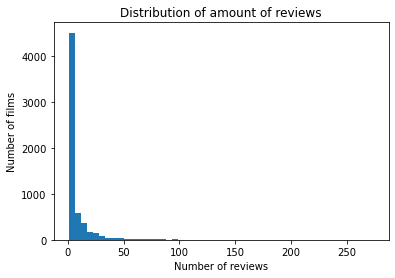

In [12]:
_ = plt.hist(df.sum(), 50)
plt.xlabel("Number of reviews")
plt.ylabel("Number of films")
plt.title("Distribution of amount of reviews")

So we see that most of the films are rather rarely reviewed. Most of them appears only few times, so support for itemsets containing these films will be very small. As a result these films won't be included in any association rule. What to do if user starts watching from these films, what to recommend then?

We have 671 movies, so if we set support to 5% then movie needs to be at least 34 times reviewed so we will reject most of the movies

Moreover movies that were watched many times, may be classics and these are being shown in everyone's basket. So they will
create very big itemsets that do not bring anything new, as everyone likes classic films

So maybe different approach would work better. I think that we are not very interested in very long associations rules, but rather shorter ones
So that based on 2/3 lastly seen movies we can with high precission recommend next 1/2 to watch. `So maybe a good idea would be to restrict the length of itemsets`

### Now let's see how many reviews one users give

In [13]:
df.sum(axis=1).describe()

count     671.000000
mean       76.852459
std       106.181753
min         1.000000
25%        20.000000
50%        41.000000
75%        88.500000
max      1115.000000
dtype: float64

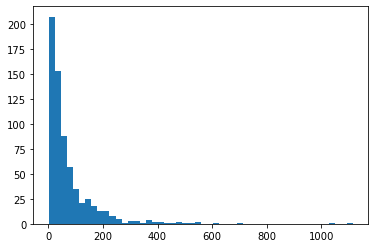

In [14]:
_ = plt.hist(df.sum(axis=1), 50)

Again trend is very similar. Most of the users do not give that many reviews. However, we have some outliers who gave more than 1k positive reviews. Are these critics? Or these are bots that comment everything positively? Should we do anything with them? 

### Creating frequent datasets

Let's try at first typical setting with min support 5% which corresponds to a films being watched 34 times

In [15]:
frequent_itemsets = fpgrowth(df, min_support=0.05, use_colnames=True) #fpgrowth is much faster than apriori

In [16]:
frequent_itemsets

,support,itemsets
0,0.053651,(1172)
1,0.375559,(296)
2,0.307004,(527)
3,0.257824,(50)
4,0.253353,(589)
...,...,...
17192,0.052161,"(296, 46578)"
17193,0.052161,"(8360, 4306)"
17194,0.062593,"(587, 356)"
17195,0.050671,"(260, 1517)"


In [17]:
frequent_itemsets.shape

(17197, 2)

In [18]:
positive_ratings_rules = association_rules(frequent_itemsets, metric='lift', min_threshold=5.0)

In [19]:
#Let's calculate how many films the rules covered, So let's just check how many distinct antecedents we have
all_films = set()
for index, films in positive_ratings_rules.antecedents.iteritems():
    all_films = all_films.union(films)

len(all_films) 

102

This make no sense to use only 100 films out of 6k possible! So definitelly we need to change the approach and maybe try to restrict length of frequent itemsets.

Let's try some extreme setting to see if we are able to cover more films using smaller support but restricting max length of the rule

`with min_support set to 0.01 it runs about 7 minutes! you can decrease it. I was curious what it would give.`

In [24]:
frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True, max_len=3) 
#Basically difference between sizes of frequent itemsets even if we change support by a little here is very big

In [25]:
frequent_itemsets.shape # So we have MUCH more frequent itemsets (probably most of them is thrash), but do we even cover more films?

(2283883, 2)

In [26]:
positive_ratings_rules = association_rules(frequent_itemsets, metric='lift', min_threshold=5.0)

In [27]:
#Let's calculate how many films the rules covered
all_films = set()
for index, films in positive_ratings_rules.antecedents.iteritems():
    all_films = all_films.union(films)

len(all_films) 

1413

Still not that many films. Only 1413 from 6k in corpus (9k in entire database). Probability that first watched film won't be from that pool is about $\frac{1413}{6000} \approx 80\%$, that 2 films are not from that pool about 50% `(I assumed independence and just muliply probabilities in reality this probably differs.)` so it is very likely that even after watching a few films we will still be forced to show some random recomendations.

Moreover some rules may still be conjunctions $A \wedge B -> C$ and we may not have just $A -> C$ in the base (proofed this to myself by simple van diagram). So what if user watched just A? We can make poor assumptions that $A \wedge B ->C <=> A -> C \wedge B -> C$ But this in some cases may give strange results. As an example If someone liked romance and horror then for sure they will like some romance with horror elements but if they just liked romance it make no sense to assume they will like merge of them

Another thing would be to assume symmetricity and one step transitivity of these rules (This is may be closer to the true in case of films than previous assumption). So if user liked movie A, but we do not have any rule A -> X, then we check if we have anything B -> A. Then, we could assume that all rules B -> X, where X is random film hold also for A. So then we can also use movies that are only consequents. But how much more we have then?

In [28]:
#Additionally add consequents to all possible films
for index, films in positive_ratings_rules.consequents.iteritems():
    all_films = all_films.union(films)
len(all_films)

1413

Didn't expected that we won't gain anything... So maybe this symmetricity holds with such a small support?

Next idea I have is to incorporate Multilevel Association Rules and use information about film genres, which I've previously dropped. If rules incorporating genres will be trivial and not helping at all, then eventually if we do not have information in rules, we can use correlation between genres or just recommend random movie from the same genre as previosuly watched one.

In [29]:
movies_genre = pd.read_csv(os.path.join(data_folder, "movies.csv"))

In [30]:
#Creating a mapping from film_id to [film_name, film_genres] 
movies_mapping_genre = {}
all_genres = set()
for index, row in movies_genre.iterrows():
    movies_mapping_genre[row.movieId] = []
    movies_mapping_genre[row.movieId].append(row.title)
    movie_genres = row.genres.split("|")
    all_genres = all_genres.union(set(movie_genres))
    movies_mapping_genre[row.movieId].append(movie_genres)

In [31]:
print(all_genres)  # no genres listed.. We should do something with this probably

{'Documentary', 'Adventure', 'Crime', 'Fantasy', 'Animation', 'Drama', 'Mystery', 'Children', 'Western', 'Horror', 'Romance', 'War', 'IMAX', 'Action', 'Thriller', 'Musical', '(no genres listed)', 'Comedy', 'Film-Noir', 'Sci-Fi'}


In [33]:
#and movies withouth a genre are reviewed, so not sure what should I do here with that category
len(set(ratings.movieId).intersection(set(movies_genre[movies_genre["genres"]=="(no genres listed)"].movieId))) 

17

Let's count which genres user like. I assume a user like genre if balance liked_movies_from_genre - not_liked_movies_from_genre is positive

In [34]:
from collections import defaultdict

all_genres_list_sorted = sorted(list(all_genres)) # I want this mapping to always be the same, with set this may not be the case
mapping_genre_to_numbers = {v:k for k,v in zip(range(len(all_genres)), all_genres_list_sorted)}

# mapping_genre_to_numbers_shifted_by_films = {v:k for k,v in zip(range(len(all_genres)), all_genres_list_sorted)}  
num_of_genres = len(all_genres) 

user_genres = defaultdict(lambda : [0] * num_of_genres)

#maybe this could be vectorized but not sure how to do it
for index, row in useful_ratings.iterrows():
    userId, movieId, rating = row
    for genre in movies_mapping_genre[movieId][1]:
        user_genres[userId][mapping_genre_to_numbers[genre]] += rating #ratings now are either 1 or -1
        

In [35]:
genres_sentiment = pd.DataFrame(user_genres).transpose()
genres_sentiment.columns = all_genres_list_sorted
genres_sentiment # We get new cool dataframe

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0,-1,-5,-2,-1,-3,0,0,-2,-3,0,0,0,0,0,0,-1,-1,-1,0
2,0,4,7,3,3,3,5,0,19,2,0,2,1,2,4,8,3,7,3,2
3,0,5,2,-1,-1,8,4,1,16,0,0,1,-1,-1,1,4,0,4,5,1
4,0,47,51,22,37,69,25,1,48,32,1,10,1,23,6,26,32,29,4,0
5,0,10,12,6,9,39,4,1,24,8,0,2,4,8,0,30,5,5,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0,4,4,4,4,14,5,0,22,4,0,0,1,2,1,6,3,7,4,0
668,0,1,0,0,0,2,6,0,10,1,0,1,0,0,0,1,0,3,2,0
669,0,4,3,0,0,6,2,0,4,0,1,-3,0,0,1,1,-2,0,0,1
670,0,2,2,1,2,3,4,0,9,1,-2,1,0,0,1,3,3,5,2,-1


In [36]:
genres_sentiment_class = genres_sentiment.apply(lambda x: np.sign(x)) #now if anyone likes a genre it get 1 if don't it get -1 if 0 then we do not care

Merging genres information with film information was not the best idea as then we then have just too much trivial frequent sets and algorithm works veeery slow. Im just leaving the cell in which I've merged these two.

In [37]:
positive_transactions_film_and_genre = []
for userId in users_train:
    liked_movies = list(useful_ratings_positive[useful_ratings_positive.userId == userId].movieId + num_of_genres)  # not to have ovelapping genre indices with film indices
    #so first 19 indices are devoted for genres
    liked_genres = np.argwhere((genres_sentiment_class.loc[userId] == 1).to_numpy())
    positive_transactions_film_and_genre.append(list(liked_genres.flatten()) + liked_movies )
    

Okay so maybe we can just try to learn which genre works well with one another and if user hasn't watched enough movies recommend based on the genre information. And it seems that this baskets have completely different characteristic. As we have only 17 elements in it to have reasonable outcomes min_support should be much higher. However the lift values should be rather small to get any rules not filtered

In [38]:
positive_transactions_genre = []
for userId in users_train:
    liked_genres = np.argwhere((genres_sentiment_class.loc[userId] == 1).to_numpy())
    positive_transactions_genre.append(list(liked_genres.flatten()) )

In [42]:
te = TransactionEncoder()
te_array = te.fit_transform(positive_transactions_genre)

df = pd.DataFrame(te_array, columns=te.columns_)

frequent_itemsets = fpgrowth(df, min_support=0.6, use_colnames=True, max_len=4) #in that case we have small amount of items and they probably are quite often
#So support should be high, I also think that constraining size of the frequent itemset is a good idea

In [47]:
frequent_itemsets

,support,itemsets
0,0.940387,(8)
1,0.891207,(6)
2,0.874814,(17)
3,0.862891,(15)
4,0.853949,(5)
...,...,...
550,0.600596,"(9, 3)"
551,0.605067,"(8, 2, 3)"
552,0.605067,"(8, 3, 6)"
553,0.602086,"(8, 3, 5)"


In [52]:
positive_genres_rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2) 
# generally lift is quite small in that case to get anything passed

In [53]:
positive_genres_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(1, 2, 17)",(16),0.754098,0.760060,0.688525,0.913043,1.201279,0.115365,2.759314
1,"(16, 2)","(1, 17)",0.719821,0.794337,0.688525,0.956522,1.204177,0.116744,4.730253
2,"(16, 17)","(1, 2)",0.730253,0.773472,0.688525,0.942857,1.218993,0.123694,3.964232
3,"(1, 2)","(16, 17)",0.773472,0.730253,0.688525,0.890173,1.218993,0.123694,2.456114
4,"(1, 17)","(16, 2)",0.794337,0.719821,0.688525,0.866792,1.204177,0.116744,2.103314
...,...,...,...,...,...,...,...,...,...
147,(4),"(8, 9, 5)",0.678092,0.719821,0.603577,0.890110,1.236571,0.115471,2.549627
148,(3),(4),0.651267,0.678092,0.603577,0.926773,1.366736,0.161958,4.396051
149,(4),(3),0.678092,0.651267,0.603577,0.890110,1.366736,0.161958,3.173472
150,(9),(3),0.758569,0.651267,0.600596,0.791749,1.215705,0.106565,1.674578


Lets check how many rules consider just one genre as antecedent. It is only 4 so not good...

In [61]:
#SO with that setting only genre number 3 is included
single_antecedent_genres = set()

for i in positive_genres_rules.antecedents.iteritems():
    if len(i[1]) == 1:
        single_antecedent_genres = single_antecedent_genres.union(set(i[1]))

print(len(single_antecedent_genres))

4


I think that we could look for associations rules iteratively at the very end. At first try to create very short rules (only A->B) but with low support not to miss the rarest film rules. And then in each iteration increase minsupport and allowed rule length. After that we could somehow filter these rules further for all the films selecting just these with the biggest support and lift. With this approach we probably would be able to cover a lot of films.

Yet another idea is to somehow see if there is some kind of correlation between genres that we can observe. we can treat every column as a one random variable. I think that we are mostly interested in that binary random variable. If we take counts into account, the variance is much bigger. In general our goal is not to predict how many films someone will watch but just if they will like it.

It is quite interesting that there are some genres with high positive correlation with another, so if we like Action probably we will like Adventure too. However, negative correlation between genres never occured this is probably due to smaller amount of negative reviews at all. So If we like Adventure it does not determine that we won't like documentary, correlation(adventure, documentary) is rather small so then it probably depends on how good particular film is and not on genre itself.

In [63]:
num_of_genres = len(genres_sentiment_class.columns)
genres_sentiment_correlation = genres_sentiment_class.corr()
genres_sentiment_correlation.values[np.arange(num_of_genres), np.arange(num_of_genres)] = -2 # I don't want to have this obvious correlations in the top-k correlations
#-2 as I do not need negatively correlated variables anyway
genres_sentiment_correlation

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
(no genres listed),-2.000000,0.072428,0.054559,0.060091,0.041671,0.070159,0.074499,0.105530,0.022034,0.079907,0.057415,0.083712,0.116656,0.069104,0.084376,0.072541,0.032693,0.072219,0.042681,0.068888
Action,0.072428,-2.000000,0.620187,0.301987,0.333484,0.499832,0.421918,0.077340,0.396255,0.386283,0.065782,0.310594,0.297404,0.184473,0.420163,0.475434,0.588742,0.607969,0.375418,0.273856
Adventure,0.054559,0.620187,-2.000000,0.444931,0.536862,0.567869,0.358604,0.073244,0.491780,0.579899,0.121610,0.251667,0.392071,0.322965,0.370934,0.561921,0.566374,0.546369,0.348233,0.295900
Animation,0.060091,0.301987,0.444931,-2.000000,0.746318,0.400014,0.267921,0.135440,0.339384,0.524819,0.099279,0.207543,0.384757,0.537097,0.268271,0.349184,0.323964,0.278144,0.291722,0.257724
Children,0.041671,0.333484,0.536862,0.746318,-2.000000,0.463204,0.243853,0.130146,0.335374,0.606182,0.087675,0.201670,0.361771,0.509702,0.248060,0.394670,0.360690,0.308931,0.293932,0.260711
Comedy,0.070159,0.499832,0.567869,0.400014,0.463204,-2.000000,0.443361,0.121408,0.456537,0.577836,0.083885,0.311831,0.169237,0.372088,0.377169,0.637221,0.430874,0.505719,0.315629,0.314351
Crime,0.074499,0.421918,0.358604,0.267921,0.243853,0.443361,-2.000000,0.195110,0.515535,0.388604,0.144717,0.317717,0.220753,0.213467,0.466403,0.346363,0.388698,0.529792,0.294340,0.225280
Documentary,0.105530,0.077340,0.073244,0.135440,0.130146,0.121408,0.195110,-2.000000,0.167631,0.130072,0.348751,0.103488,0.132187,0.198055,0.165501,0.147262,0.036460,0.115036,0.178522,0.165732
Drama,0.022034,0.396255,0.491780,0.339384,0.335374,0.456537,0.515535,0.167631,-2.000000,0.369551,0.101185,0.242217,0.202953,0.321355,0.391973,0.512735,0.326998,0.520476,0.434633,0.246398
Fantasy,0.079907,0.386283,0.579899,0.524819,0.606182,0.577836,0.388604,0.130072,0.369551,-2.000000,0.151663,0.285250,0.326138,0.410207,0.345749,0.487521,0.403993,0.373021,0.260921,0.290930


In [65]:
genres_sentiment_correlation.max() # the strongest correlations are quite weak still.

(no genres listed)    0.116656
Action                0.620187
Adventure             0.620187
Animation             0.746318
Children              0.746318
Comedy                0.637221
Crime                 0.529792
Documentary           0.348751
Drama                 0.520476
Fantasy               0.606182
Film-Noir             0.348751
Horror                0.419584
IMAX                  0.392071
Musical               0.537097
Mystery               0.517156
Romance               0.637221
Sci-Fi                0.588742
Thriller              0.607969
War                   0.434633
Western               0.314351
dtype: float64

In [66]:
#Lets select only best 4 correlations
best_correlations = {}
for i, (genre_name, correlations) in enumerate(genres_sentiment_correlation.iteritems()):
    best_correlations[genre_name] = correlations.sort_values(ascending=False)[:4]

best_correlations["Action"]

Adventure    0.620187
Thriller     0.607969
Sci-Fi       0.588742
Comedy       0.499832
Name: Action, dtype: float64

Last thing could be to select best films from given genre

In [68]:
best_films_in_genre = defaultdict(lambda : [])

for movieId, positive_ratings in useful_ratings.groupby("movieId").rating.sum().iteritems():
    name, genres = movies_mapping_genre[movieId]
    for genre in genres:
        best_films_in_genre[genre].append((name, positive_ratings))

for genre, films in best_films_in_genre.items():
    best_films_in_genre[genre] = sorted(films, key = lambda x: x[1], reverse=True)

In [69]:
best_films_in_genre["Romance"][:5] #not sure why forrest gump and shrek are romances but fine

[('Forrest Gump (1994)', 236),
 ('American Beauty (1999)', 173),
 ('Princess Bride, The (1987)', 124),
 ('Good Will Hunting (1997)', 119),
 ('Shrek (2001)', 102)]

In [70]:
movies_genre[movies_genre.title=='Forrest Gump (1994)'] # So for sure so more restrictive genres mapping would be nice

,movieId,title,genres
321,356,Forrest Gump (1994),Comedy|Drama|Romance|War


### So this is the end of the analysis and now let's move to the actual implementation
Think recommender will think in a hierarchical approach:

* First it looks in the assosiactions rules concerning concrete films (This will be build iteratively starting from low support and low rule length ending in bigger support and a little bit longer rules). However the length of the frequent sets will be at most 4/5.
* If it doesn't find anything there. Then it moves to the rules about genres, build in the same way. 
* If still no results we utilize the correlation matrix to find which genre would be good
* If we have a genre we will just try to reccomend not viewed movies starting from the best\worst ones.


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from itertools import chain, combinations

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [3]:
class FilmTransformer:
    """This class performs necessary transformation to the dataset
    """
    def __init__(self,):
        pass

    def binarize_ratings(self, ratings, negative_bound=2, positive_bound=4):
        """Instead of rating on numerical scale we obtain either 1 (positive) or -1 (negative) ratings

        Args:
            ratings (_type_): _description_
            negative_bound (int, optional): Which is biggest score for negative. Defaults to 2.
            positive_bound (int, optional): What is smaller score for positive. Defaults to 4.

        Returns:
            _type_: binarized DataFrame
        """
        mask_with_useful_ratings = (ratings.rating >=positive_bound)  | (ratings.rating <= negative_bound)

        useful_ratings = ratings.copy().loc[mask_with_useful_ratings,:]
        
        useful_ratings["rating"] = useful_ratings.rating.apply(lambda x: 1 if x >= 4 else -1)

        return useful_ratings


In [4]:
class FilmDataset:
    """Object storing all the information concerning the Films
    """
    def __init__(self, movies_path, ratings_path):
        self.transformer = FilmTransformer()

        self.movies_path = movies_path
        self.ratings_path = ratings_path

        self.movies = pd.read_csv(os.path.join(data_folder, "movies.csv"))
        self.ratings = pd.read_csv(os.path.join(data_folder, "ratings.csv")).drop("timestamp", axis=1)

        self.ratings = self.transformer.binarize_ratings(self.ratings)

        self.ratings_positive = self.ratings[self.ratings.rating == 1]
        self.ratings_negative = self.ratings[self.ratings.rating == -1]

    def get_positive_transactions(self, users_id):
        return [
            list(self.ratings_positive[self.ratings_positive.userId == x].movieId)
            for x in users_id
        ]
    
    def get_negative_transactions(self, users_id):
        return [
            list(self.ratings_negative[self.ratings_negative.userId == x].movieId)
            for x in users_id
        ]


In [5]:
class FilmMetadata():
    """Class containing all meta information about films (should be split into 2 classes probably). 
       All needed mappings, users that gave positive rating
       also ranking films from all genres sorted w.r.t most positively reviewed
    """
    def __init__(self, dataset : FilmDataset):
        self.dataset = dataset
        self.update_movies_mapping()
        self.update_best_worst_films()

        self.users_positive =self.dataset.ratings_positive.userId.unique()
        self.num_of_positive_users = self.users_positive.size

        self.users_negative =self.dataset.ratings_negative.userId.unique()
        self.num_of_negative_users = self.users_negative.size    

    def update_movies_mapping(self):
        self.id_to_movie_mapping = {} # at each id we have a movie title and genres
        self.movie_to_id_mapping = {} #mapping in other direction also is needed
        self.all_genres = set() #all genres that exists

        for index, row in self.dataset.movies.iterrows():
            self.id_to_movie_mapping[row.movieId] = {}
            self.id_to_movie_mapping[row.movieId]["title"] = row.title
            self.movie_to_id_mapping[row.title] = row.movieId

            movie_genres = row.genres.split("|")
            self.id_to_movie_mapping[row.movieId]["genres"] = movie_genres

            self.all_genres = self.all_genres.union(set(movie_genres))
            
        self.num_of_genres = len(self.all_genres)

    def update_best_worst_films(self,):
        self.best_films_in_genre = defaultdict(lambda : [])
        self.worst_films_in_genre = defaultdict(lambda : []) #worst films are just best reversed

        for movieId, positive_ratings in self.dataset.ratings.groupby("movieId").rating.sum().iteritems():
            name, genres = self.id_to_movie_mapping[movieId].values()
            for genre in genres:
                self.best_films_in_genre[genre].append((name, positive_ratings))

        for genre, films in self.best_films_in_genre.items():
            self.best_films_in_genre[genre] = sorted(films, key = lambda x: x[1], reverse=True)
            self.worst_films_in_genre[genre] = self.best_films_in_genre[genre][::-1]

    #Some mapping functions
    def numbers_to_movies(self, numbers):
        return [self.id_to_movie_mapping[num]["title"] for num in numbers]

    def movies_to_numbers(self, movies):
        return [self.movie_to_id_mapping[title] for title in movies]

    def get_movies_genre(self, movie_id):
        return self.id_to_movie_mapping[movie_id]["genres"]
    

In [6]:
class GenreDataset():
    """Class containing the Genre data
    """
    def __init__(self, film_dataset: FilmDataset, metadata: FilmMetadata):
        self.metadata = metadata
        self.film_dataset = film_dataset
        
        self.all_genres_list_sorted = sorted(list(self.metadata.all_genres)) # to has always the same mapping
        self.mapping_genre_to_numbers = {v:k for k,v in zip(range(len(self.metadata.all_genres)), self.all_genres_list_sorted)}
        self.mapping_numbers_to_genre = {v:k for k,v in self.mapping_genre_to_numbers.items()}
 
        user_genres = defaultdict(lambda : [0] * self.metadata.num_of_genres)

        #So here based on film data we prepare genre data
        for index, row in self.film_dataset.ratings.iterrows():
            userId, movieId, rating = row
            for genre in self.metadata.id_to_movie_mapping[movieId]["genres"]:
                user_genres[userId][self.mapping_genre_to_numbers[genre]] += rating

        self.genres_sentiment = pd.DataFrame(user_genres).transpose()
        self.genres_sentiment.columns = self.all_genres_list_sorted

        self.genres_sentiment = self.genres_sentiment.apply(lambda x: np.sign(x))

    def get_positive_transactions(self, users_id):
        positive_transactions_genre = []
        #I should vectorize it
        for userId in users_id:
            liked_genres = np.argwhere((self.genres_sentiment.loc[userId] == 1).to_numpy())
            positive_transactions_genre.append(list(liked_genres.flatten()))

        return positive_transactions_genre

    def get_negative_transactions(self, users_id):
        negative_transactions_genre = []
        for userId in users_id:
            not_liked_genres = np.argwhere((self.genres_sentiment.loc[userId] == -1).to_numpy())
            negative_transactions_genre.append(list(not_liked_genres.flatten()))

        return negative_transactions_genre

    def numbers_to_genres(self, numbers):
        return [self.mapping_numbers_to_genre[num] for num in numbers]

    def genres_to_numbers(self, genres):
        return [self.mapping_genre_to_numbers[g] for g in genres]

    

    

In [7]:
class Rules:
    """Class containing all the association rules
       It shouldn't cover positive and negative in the same time but instead we should have two instances of the same class.
        Not the best code, sorry for that
    """
    def __init__(self, dataset : FilmDataset, metadata: FilmMetadata, metric="lift", min_threshold=5, min_supports_pos=[0.01, 0.02, 0.03], min_supports_neg=[0.01,0.02,0.03]):
        self.te_positive = TransactionEncoder()
        self.te_negative = TransactionEncoder()

        self.dataset = dataset
        self.metadata = metadata

        te_array = self.te_positive.fit_transform(self.dataset.get_positive_transactions(self.metadata.users_positive))
        self.df_positive = pd.DataFrame(te_array, columns=self.te_positive.columns_)
        self.te_positive_id_to_filmId = {v:k for k,v in self.te_positive.columns_mapping_.items()}

        te_array = self.te_negative.fit_transform(self.dataset.get_negative_transactions(self.metadata.users_negative))
        self.df_negative = pd.DataFrame(te_array, columns=self.te_negative.columns_)
        self.te_negative_id_to_filmId = {v:k for k,v in self.te_negative.columns_mapping_.items()}

        self.metric = metric
        self.min_threshold = min_threshold
        self.min_supports_pos = min_supports_pos
        self.min_supports_neg = min_supports_neg
    
    def fit(self,):
        self.positive_rules = self.fit_procedure(self.df_positive, self.min_supports_pos)
        self.negative_rules = self.fit_procedure(self.df_negative, self.min_supports_neg)

    def fit_procedure(self, df, min_supports):
        max_lengths = [2,3,4]

        #To make this fast I assume that we can choose any film B having X as antecedent. 
        # So we can just store all the consequents for given antecedent in a dictonary
        #And for different antecedents length Ill have separate dictonaries
        #and then during inference we can just do a quick lookup
        num_of_antecedents = [1,2,3]
        rules_with_n_antecedents = {antecedents:defaultdict(lambda : set()) for antecedents in num_of_antecedents}
        
        for i, (min_supp, max_length) in enumerate(zip(min_supports, max_lengths)):
            frequent_itemsets = fpgrowth(df, min_support=min_supp, use_colnames=True, max_len=max_length)
            rules = association_rules(frequent_itemsets, metric=self.metric, min_threshold=self.min_threshold)

            if i > 0:
                # I already have all rules with max_length - 1 so I am only interested in the shorter ones
                shorter_rules_filter = rules.apply(lambda x: len(x.antecedents.union(x.consequents)), axis=1) > max_lengths[i-1]
                rules = rules[shorter_rules_filter]

            #Here I update all previously gathered rules of each length by new consequents
            for id, rule in rules.iterrows():
                antecedents = tuple(sorted(list(rule.antecedents)))
                consequents = rule.consequents

                for ant_len in num_of_antecedents[:i+1]:
                    if len(antecedents) == ant_len:
                        rules_with_n_antecedents[ant_len][antecedents] = rules_with_n_antecedents[ant_len][antecedents].union(consequents)

        return rules_with_n_antecedents
    
    def get_all_possible_consequents(self, antecedents: tuple, rules):
        """Here we tru to get all possible consequents and if e.g someone gave 4 films. Then if we do not suceed with all 4 films
        We look if some subset of these 4 films have a consequent
        """
        antecedents = tuple(sorted(antecedents))
        if len(antecedents) in rules and antecedents in rules[len(antecedents)]:
            yield rules[len(antecedents)][antecedents]

        all_subsets = chain.from_iterable(combinations(antecedents, r) for r in range(1, min(4, len(antecedents)+1))) # from smallest to biggest
        all_subsets_from_biggest = sorted(list(all_subsets), key = lambda x: len(x), reverse=True)
        for smaller_antecedents in all_subsets_from_biggest:
            if smaller_antecedents in rules[len(smaller_antecedents)]:
                yield rules[len(smaller_antecedents)][smaller_antecedents]


    def transform(self, antecedents, positive=True,):
        #Now after few days I see it is not well written...
        rules = self.positive_rules if positive else self.negative_rules
        te = self.te_positive if positive else self.te_negative
        mapping = self.te_positive_id_to_filmId if positive else self.te_negative_id_to_filmId

        antecedents = [te.columns_mapping_[a] for a in antecedents] # we must come back to the mapping created by TE
        for consequent in self.get_all_possible_consequents(antecedents, rules):
            if len(consequent) > 0:
                return [mapping[c] for c in consequent]

        return []
        
    

In [8]:
class CorrelationRule:
    """Separate class applying the best correlation rule
    """
    def __init__(self, dataset: GenreDataset, metadata: FilmMetadata):
        self.dataset = dataset
        self.metadata = metadata

        self.genres_sentiment_correlation = self.dataset.genres_sentiment.corr()
        self.genres_sentiment_correlation.values[np.arange(self.metadata.num_of_genres), np.arange(self.metadata.num_of_genres)] = -2

        self.best_correlations = {}
        for i, (genre_name, correlations) in enumerate(self.genres_sentiment_correlation.iteritems()):
            self.best_correlations[genre_name] = correlations.sort_values(ascending=False)[:4]

    def transform(self, genre):
        #during selecting genre each has weight proportional to the correlation value
        genre_names = self.best_correlations[genre].index
        weights = self.best_correlations[genre].values
        weights /= np.sum(weights)
        
        genre_num = np.random.choice(np.arange(len(weights)), size=1, p=weights)

        selected_genre = genre_names[genre_num].values[0]

        return selected_genre
        

In [9]:
class Recommender:
    """The final class using all the previously written modules
    """
    def __init__(self, rules_film: Rules, rules_genre : Rules, correlation_rules: CorrelationRule, metadata : FilmMetadata, genre_dataset: GenreDataset):
        self.rules_film = rules_film
        self.rules_genre = rules_genre
        self.correlation_rules = correlation_rules

        self.metadata = metadata
        self.genre_dataset = genre_dataset

    def select_film(self, selected_genre, previously_watched, positive):
        """Given the selected genre this function try to suggest best or worst films
           and it stops when it find a film not previously_watched by the user
        """
        films_to_choose_from = self.metadata.best_films_in_genre if positive else self.metadata.worst_films_in_genre
        for film in films_to_choose_from[selected_genre]:
            name, positive_score = film
            if name not in previously_watched:
                return name

    def remove_watched(self, selected, previously_watched):
        return [s for s in selected if s not in previously_watched]    

    def recommend(self, antecedents, previously_watched, positive=True):
        """This function basically try to use all the rules until one of them suceed
        """
        antecedents = tuple(self.metadata.movies_to_numbers(antecedents))
        

        films = self.rules_film.transform(antecedents, positive)
        films = self.metadata.numbers_to_movies(films)
        films_filtered = self.remove_watched(films, previously_watched)
        
        if films_filtered:
            return films_filtered
        
        for a in antecedents:
            antecedent_genres = self.genre_dataset.genres_to_numbers(self.metadata.get_movies_genre(a))
            genres = self.rules_genre.transform(tuple(antecedent_genres), positive)
            if genres:
                genres = self.genre_dataset.numbers_to_genres(genres)
                selected_genre = np.random.choice(genres)
                
                return self.select_film(selected_genre, previously_watched, positive)
                    
        for a in antecedents:
            for genre in self.metadata.get_movies_genre(a):
                selected_genre = self.correlation_rules.transform(genre)
                return self.select_film(selected_genre, previously_watched, positive)
        

        
            
    
        
        

When we have all the classes we just need to initialize every object. We could do this every day as our database of films increase.
`This code runs for about 2 minutes. But after that everything is stored in dictonaries so inference is just a simple lookup.`

In [10]:
data_folder = "data"
movies_path = os.path.join(data_folder, "movies.csv")
ratings_path = os.path.join(data_folder, "ratings.csv")

film_dataset = FilmDataset(movies_path, ratings_path)
metadata = FilmMetadata(film_dataset)

genre_dataset = GenreDataset(film_dataset, metadata)

rules_film = Rules(film_dataset, metadata, min_threshold=7)
rules_film.fit()

rules_genre = Rules(genre_dataset, metadata, min_threshold = 1.25, min_supports_pos=[0.4, 0.5, 0.6], min_supports_neg=[0.05,0.1,0.15])
rules_genre.fit()

correlation_rules = CorrelationRule(genre_dataset, metadata)


In [27]:
recommender = Recommender(rules_film, rules_genre, correlation_rules, metadata, genre_dataset)

In [32]:
#I liked films Pulp Fiction and Reservoir Dogs what to watch next?
recommender.recommend({"Pulp Fiction (1994)", "Reservoir Dogs (1992)"}, set(["Pulp Fiction (1994)", "Reservoir Dogs (1992)"]))

'Silence of the Lambs, The (1991)'

In [28]:
# I didn't like the mask what not to watch next? 
recommender.recommend({"Mask, The (1994)"}, set("Mask, The (1994)"), positive=False)

['French Kiss (1995)']

In [29]:
#I've watched and liked Grumpier Old Men - what to watch next?
recommender.recommend({'Grumpier Old Men (1995)'}, set('Grumpier Old Men (1995)'))

['Pallbearer, The (1996)',
 'First Wives Club, The (1996)',
 'Ransom (1996)',
 'Crow: City of Angels, The (1996)',
 'Dragonheart (1996)',
 'Powder (1995)',
 'Bad Company (1995)',
 'Tie That Binds, The (1995)']

In [30]:
#I've watched, bad company  too from these, so it would not be included
recommender.recommend({'Grumpier Old Men (1995)', 'Bad Company (1995)'}, set(['Grumpier Old Men (1995)', 'Bad Company (1995)']))

['Pallbearer, The (1996)',
 'First Wives Club, The (1996)',
 'Ransom (1996)',
 'Crow: City of Angels, The (1996)',
 'Dragonheart (1996)',
 'Powder (1995)',
 'Tie That Binds, The (1995)']

In [32]:
#I've watched, all from that list but I liked only these two
recommender.recommend({'Grumpier Old Men (1995)', 'Bad Company (1995)'}, 
set(['Grumpier Old Men (1995)', 'Bad Company (1995)','Pallbearer, The (1996)',
 'First Wives Club, The (1996)',
 'Ransom (1996)',
 'Crow: City of Angels, The (1996)',
 'Dragonheart (1996)',
 'Powder (1995)',
 'Tie That Binds, The (1995)'
 ]))

'Forrest Gump (1994)'

In [33]:
#I've watched star Wars But I didn't like it, what shouldn't I watch?
recommender.recommend({'Star Wars: Episode IV - A New Hope (1977)'}, 
set(['Grumpier Old Men (1995)', 'Bad Company (1995)','Pallbearer, The (1996)',
 'First Wives Club, The (1996)',
 'Ransom (1996)',
 'Crow: City of Angels, The (1996)',
 'Dragonheart (1996)',
 'Powder (1995)',
 'Tie That Binds, The (1995)',
 'Star Wars: Episode IV - A New Hope (1977)'
 ]), positive=False)

'Hollow Man (2000)'